# LSTM

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing

In [3]:
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


## Data processing
### PM2.5

In [35]:
# Data preparation
df = pd.read_csv('model_data_pi_hours.csv') # You need to c
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.iloc[:138,:]

In [36]:
# Split train & test
n = len(df)
train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]

In [37]:
train_df

,temp_pi_t0,hum_pi_t0,PM1_pi_t0,PM2.5_pi_t0,PM10_pi_t0,wind_speed_t0,temp_pi_t1,hum_pi_t1,PM1_pi_t1,PM2.5_pi_t1,...,wind_speed_t4,temp_pi_t5,hum_pi_t5,PM1_pi_t5,PM2.5_pi_t5,PM10_pi_t5,wind_speed_t5,PM2.5_pi,PM10_pi,hour
0,17.625000,30.933333,4.365000,9.65250,15.223333,9.826088,19.983333,28.125000,4.610000,10.0425,...,6.924738,8.316667,53.283333,6.042500,11.798333,17.710000,5.116561,6.641000,9.477000,14.0
1,13.990000,35.770000,3.787000,6.64100,9.477000,8.209263,17.625000,30.933333,4.365000,9.6525,...,7.421590,13.408333,38.358333,4.840833,10.010000,15.388333,6.924738,10.465000,16.762500,15.0
2,12.683333,37.733333,4.529167,10.46500,16.762500,8.496304,13.990000,35.770000,3.787000,6.6410,...,6.952755,17.391667,32.191667,5.140833,7.510833,9.632500,7.421590,6.040000,9.553333,16.0
3,11.616667,40.350000,2.710000,6.04000,9.553333,7.754637,12.683333,37.733333,4.529167,10.4650,...,11.269782,18.650000,30.083333,3.752500,6.064167,8.284167,6.952755,7.147500,10.535000,17.0
4,10.425000,42.900000,3.815000,7.14750,10.535000,6.162207,11.616667,40.350000,2.710000,6.0400,...,9.826088,19.983333,28.125000,4.610000,10.042500,15.750000,11.269782,7.878333,12.093333,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,10.900000,54.850000,1.635000,4.46000,7.517500,25.050413,8.680000,64.740000,1.561000,4.1460,...,19.959720,9.587500,81.237500,1.951250,4.691250,7.617500,18.118410,4.378000,7.250000,9.0
92,11.800000,47.660000,1.707000,4.37800,7.250000,25.325686,10.900000,54.850000,1.635000,4.4600,...,20.969805,9.214286,77.042857,1.467143,4.021429,6.784286,19.959720,3.917000,6.415000,10.0
93,14.530000,43.370000,1.583000,3.91700,6.415000,24.130743,11.800000,47.660000,1.707000,4.3780,...,22.253124,8.733333,73.666667,1.033333,3.258333,5.693333,20.969805,4.705000,7.891000,11.0
94,14.900000,41.120000,1.754000,4.70500,7.891000,24.842607,14.530000,43.370000,1.583000,3.9170,...,24.858253,8.287500,69.487500,1.362500,4.062500,7.005000,22.253124,4.438750,6.758750,12.0


In [38]:
labels = ['PM2.5_pi', 'PM10_pi']

In [39]:
X_train = train_df.drop(train_df[labels], axis=1)
X_train.head()

,temp_pi_t0,hum_pi_t0,PM1_pi_t0,PM2.5_pi_t0,PM10_pi_t0,wind_speed_t0,temp_pi_t1,hum_pi_t1,PM1_pi_t1,PM2.5_pi_t1,...,PM2.5_pi_t4,PM10_pi_t4,wind_speed_t4,temp_pi_t5,hum_pi_t5,PM1_pi_t5,PM2.5_pi_t5,PM10_pi_t5,wind_speed_t5,hour
0,17.625000,30.933333,4.365000,9.6525,15.223333,9.826088,19.983333,28.125000,4.610000,10.0425,...,10.010000,15.388333,6.924738,8.316667,53.283333,6.042500,11.798333,17.710000,5.116561,14.0
1,13.990000,35.770000,3.787000,6.6410,9.477000,8.209263,17.625000,30.933333,4.365000,9.6525,...,7.510833,9.632500,7.421590,13.408333,38.358333,4.840833,10.010000,15.388333,6.924738,15.0
2,12.683333,37.733333,4.529167,10.4650,16.762500,8.496304,13.990000,35.770000,3.787000,6.6410,...,6.064167,8.284167,6.952755,17.391667,32.191667,5.140833,7.510833,9.632500,7.421590,16.0
3,11.616667,40.350000,2.710000,6.0400,9.553333,7.754637,12.683333,37.733333,4.529167,10.4650,...,10.042500,15.750000,11.269782,18.650000,30.083333,3.752500,6.064167,8.284167,6.952755,17.0
4,10.425000,42.900000,3.815000,7.1475,10.535000,6.162207,11.616667,40.350000,2.710000,6.0400,...,9.652500,15.223333,9.826088,19.983333,28.125000,4.610000,10.042500,15.750000,11.269782,18.0


In [40]:
y_train1 = train_df['PM2.5_pi']
y_train2 = train_df['PM10_pi']

In [41]:
y_train1 = y_train1.to_frame()
y_train2 = y_train2.to_frame()

In [42]:
X_test = test_df.drop(test_df[labels], axis=1)
X_test.head()

,temp_pi_t0,hum_pi_t0,PM1_pi_t0,PM2.5_pi_t0,PM10_pi_t0,wind_speed_t0,temp_pi_t1,hum_pi_t1,PM1_pi_t1,PM2.5_pi_t1,...,PM2.5_pi_t4,PM10_pi_t4,wind_speed_t4,temp_pi_t5,hum_pi_t5,PM1_pi_t5,PM2.5_pi_t5,PM10_pi_t5,wind_speed_t5,hour
110,6.658333,67.450000,2.165000,5.520833,9.129167,3.415260,6.881818,64.036364,3.126364,7.047273,...,6.236000,9.613000,5.760000,8.600000,58.325000,4.621667,10.125000,15.913333,6.034700,3.0
111,6.150000,68.733333,3.752500,6.378333,8.960833,1.138420,6.658333,67.450000,2.165000,5.520833,...,5.787000,9.666000,6.479999,8.000000,62.700000,2.994000,6.236000,9.613000,5.760000,4.0
112,5.716667,68.983333,4.670833,8.175833,11.664167,4.104631,6.150000,68.733333,3.752500,6.378333,...,5.787000,9.666000,6.638072,7.430000,62.450000,2.192000,5.787000,9.666000,6.479999,5.0
113,5.436364,70.918182,3.436364,7.400000,11.557273,2.520000,5.716667,68.983333,4.670833,8.175833,...,7.047273,11.187273,5.937272,7.430000,62.450000,2.192000,5.787000,9.666000,6.638072,6.0
114,6.166667,69.291667,3.610833,5.735833,7.756667,1.440000,5.436364,70.918182,3.436364,7.400000,...,5.520833,9.129167,3.415260,6.881818,64.036364,3.126364,7.047273,11.187273,5.937272,7.0


In [43]:
y_true1 = test_df['PM2.5_pi']
y_true2 = test_df['PM10_pi']

y_true1 = y_true1.to_frame()
y_true2 = y_true2.to_frame()

In [44]:
X_val = val_df.drop(test_df[labels], axis=1)

y_val1 = val_df['PM2.5_pi']
y_val2 = val_df['PM10_pi']
y_val1 = y_val1.to_frame()
y_val2 = y_val2.to_frame()

### Scaling of trainset

In [45]:
# X scaling
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)

# y1 scaling
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train1)
scaled_y_train1 = Yscaler.transform(y_train1)
print(scaled_y_train1.shape)
scaled_y_train1 = scaled_y_train1.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train1.shape)

# y2 scaling
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train2)
scaled_y_train2 = Yscaler.transform(y_train2)
print(scaled_y_train2.shape)
scaled_y_train2 = scaled_y_train2.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train2.shape)


(96, 37)
(96, 1)
(96,)
(96, 1)
(96,)


In [46]:
scaled_y_train1 = np.insert(scaled_y_train1, 0, 0)
scaled_y_train1 = np.delete(scaled_y_train1, -1)

scaled_y_train2 = np.insert(scaled_y_train2, 0, 0)
scaled_y_train2 = np.delete(scaled_y_train2, -1)

In [47]:
n_input = 1 #how many samples/rows/timesteps to look in the past in order to forecast the next sample 
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 1 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train1, length=n_input, batch_size=b_size) 

print(generator[0][0].shape)

'''Question: Since the dataset is already reconstructed as 'timeseries' data, I just put 'n_input=1'. Is it reasonable?''' 

(1, 1, 37)


"Question: Since the dataset is already reconstructed as 'timeseries' data, I just put 'n_input=1'. Is it reasonable?"

### Scaling of validation set

scaled_X_val = Xscaler.transform(X_val)
val_generator = TimeseriesGenerator(scaled_X_val, np.zeros(len(X_val)), length=n_input, batch_size=b_size)
print(val_generator[0][0].shape)

#### y_val1 scaling
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_val1)
scaled_y_val1 = Yscaler.transform(y_val1)
print(scaled_y_val1.shape)
scaled_y_val1 = scaled_y_val1.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_val1.shape)

scaled_y_val1 = np.insert(scaled_y_val1, 0, 0)
scaled_y_val1 = np.delete(scaled_y_val1, -1)

val_generator = TimeseriesGenerator(scaled_X_val, scaled_y_val1, length=n_input, batch_size=b_size)
print(val_generator[0][0].shape)

### Scaling of test set 

In [51]:
# Only X required
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(1, 1, 37)


## Model

In [70]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(n_input, n_features), dropout=0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               301056    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 301,313
Trainable params: 301,313
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(generator,epochs=10)

''' Question: Since the dataset is small, I thougth the augmentation is necessary. According to the documents, 'fit_generator' is more sutiable than 'fit' if the data augementation is required. I'd like to kindly ask whether this is correct.'''

''' Question2: is the validation set correctly implemented? Still doubt it..'''

Epoch 1/30
95/95 [==============================] - 3s 26ms/step - loss: 0.0262 - val_loss: 0.1280
Epoch 2/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0158 - val_loss: 0.1722
Epoch 3/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0151 - val_loss: 0.1668
Epoch 4/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0149 - val_loss: 0.1485
Epoch 5/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0139 - val_loss: 0.1452
Epoch 6/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0134 - val_loss: 0.1392
Epoch 7/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0134 - val_loss: 0.1306
Epoch 8/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0139 - val_loss: 0.1266
Epoch 9/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0133 - val_loss: 0.1387
Epoch 10/30
95/95 [==============================] - 1s 7ms/step - loss: 0.0125 - val_loss: 0.1542
Epoch 11/30
95/95 

' Question2: is the validation set correctly implemented? Still doubt it..'

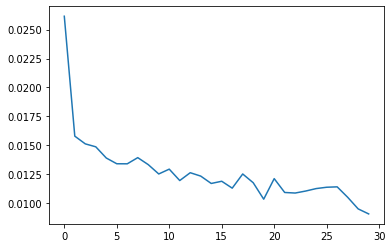

In [72]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [73]:
# Plotting
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true1':test_df['PM2.5_pi'].values[n_input:],'y_pred':y_pred.ravel()})
print(results)

plt.plot(results, label = ['Labels', 'Predictions'])
plt.xlabel('Count')
plt.ylabel('PM2.5 [ug/m3]')
plt.legend()
plt.title('Location A PM2.5')
# plt.savefig('C:/Users/ay0un/Desktop/ds-project/images/pm25_A.png')

# MSE, MAE
y_true1= test_df['PM2.5_pi'].values[n_input:]
y_pred1 = y_pred.ravel()

print("MSE: ", mean_squared_error(y_true1, y_pred1))
print("MAE: ", mean_absolute_error(y_true1, y_pred1))



      y_true1    y_pred
0    8.175833  5.418674
1    7.400000  5.671059
2    5.735833  5.840540
3    5.347273  5.880111
4    4.264000  5.838361
5    3.856667  5.850825
6    5.673000  5.682428
7    4.440000  5.462080
8    4.829091  5.596550
9    7.077500  5.303877
10   7.685000  5.497964
11   6.626364  5.776040
12   8.286667  6.010999
13   9.799167  6.219803
14   9.512500  6.467078
15   9.767500  6.356348
16   7.718333  6.373632
17   5.473636  6.476363
18   5.647500  6.166865
19   7.613636  6.017225
20   7.039167  5.995560
21   6.749167  5.624451
22   7.871667  5.349613
23   5.710833  5.570915
24   7.948333  5.892046
25  10.420000  5.582654
26   6.582727  5.879853
